<h1> Imports </h1>

In [1]:
#imports
import numpy as np
import pandas as pd

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV

import time
from datetime import date
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

<h1> Method definitions</h1>

In [121]:
def encode_onehot(df, column_name):
    return pd.get_dummies(df, columns=[column_name])

def minmax_scale(df, col):
    scaler = preprocessing.MinMaxScaler()
    df[col] = scaler.fit_transform(df[[col]])
    return df

def oversampling(df, column_name):
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=0)
    X = df.drop(column_name, axis=1)
    y = df[column_name]
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    resampled_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name=column_name)], axis=1)
    return resampled_df

def undersampling(df, column_name):
    undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=0)
    X = df.drop(columns=[column_name])
    y = df[column_name]
    
    X_undersampled, y_undersampled = undersampler.fit_resample(X, y)
    undersampled_df = pd.concat([pd.DataFrame(X_undersampled, columns=X.columns), pd.Series(y_undersampled, name=column_name)], axis=1)
    return undersampled_df

def calculateAgeWithDateOfBirth(df,column_name):
    #df[column_name]= df[column_name].strftime(df[column_name],'%Y-%m-%d').date()
    df[column_name] = pd.to_datetime(df[column_name], format='%Y-%m-%d')
    #df[column_name] = pd.to_datetime(df[column_name].dt.strftime('%Y-%m-%d'))
    print(type(df[column_name].iloc[1]))
    #current_date= datetime.now()
    current_date= pd.to_datetime(date.today())
    print(type(df[column_name].iloc[1]))
    print(df[column_name].iloc[1])
    
    df['age_in_years'] = (current_date - df[column_name]) // pd.Timedelta(365, 'D')
    df['age_in_years'] = df['age_in_years'].map(lambda x: int(x))
    df = df.drop(columns=[column_name])
    
    return df

def makeGenderBinary(df, gender_column):
    df[gender_column]=df[gender_column].map(lambda x: 1 if x == 'M' else 0)
    return df

def replace(x):
    # the categorisation of jobs was done by hand according to EEO Job Categories
    # as all the 500+ different jobs were categorised by hand some errors may occur
    # The idea is to test out if the model could be improved by job categories
    jobstoremember = {'executive': ['Theatre director'],
                      'mid-level': ['Chief Executive Officer', 'Trading standards officer', 'Chief Strategy Officer', 'Public relations account executive', 'Facilities manager', 'Fisheries officer', 'Call centre manager', 'Heritage manager', 'Travel agency manager', 'Tourist information centre manager', 'Leisure centre manager', 'Production manager', 'Chief Operating Officer', 'Chief Technology Officer', 'Fitness centre manager', 'Health service manager', 'Chief Marketing Officer', 'Farm manager', 'Information systems manager', 'Theme park manager', 'Theatre manager', 'Emergency planning/management officer', 'Quarry manager', 'Records manager', 'Location manager', 'Stage manager', 'Chief of Staff', 'Field trials officer', 'Hotel manager', 'Civil Service administrator', 'Tour manager', 'Armed forces technical officer', 'Warehouse manager'],
                      'professionals': ['Film/video editor', 'Exhibition designer', 'Naval architect', 'Surveyor, land/geomatics', 'Materials engineer', 'Designer, ceramics/pottery', 'Systems developer', 'IT trainer', 'Financial adviser', 'Environmental consultant', 'Chartered public finance accountant', 'Scientist, audiological', 'Comptroller', 'Sub', 'Podiatrist', 'Agricultural consultant', 'Magazine features editor', 'Historic buildings inspector/conservation officer', 'Librarian, public', 'Building surveyor', 'Musician', 'Water engineer', 'Scientist, research (maths)', 'Mining engineer', 'Barrister', 'Audiological scientist', 'Immunologist', 'Clothing/textile technologist', 'Financial trader', 'Claims inspector/assessor', 'Energy engineer', 'Petroleum engineer', 'Quantity surveyor', 'Make', 'Engineer, automotive', 'Mechanical engineer', 'Geoscientist', 'Counsellor', 'Secondary school teacher', 'Land/geomatics surveyor', 'Early years teacher', 'Sales professional, IT', 'Pensions consultant', 'Psychologist, forensic', 'Psychotherapist, child', 'Librarian, academic', 'Research scientist (physical sciences)', 'Electrical engineer', 'Insurance underwriter', 'Science writer', 'Chartered loss adjuster', 'Drilling engineer', 'Engineer, biomedical', 'Trade mark attorney', 'Special educational needs teacher', 'Scientist, marine', 'Cytogeneticist', 'Chemical engineer', 'Multimedia programmer', 'Accounting technician', 'Counselling psychologist', 'Toxicologist', 'Engineer, production', 'Social researcher', 'Radio producer', 'Fine artist', 'Teacher, special educational needs', 'Race relations officer', 'Engineer, control and instrumentation', 'Surveyor, minerals', 'Educational psychologist', 'Ceramics designer', 'Advertising account planner', 'Town planner', 'Programme researcher, broadcasting/film/video', 'Surgeon', 'Futures trader', 'Television/film/video producer', 'Further education lecturer', 'Scientist, biomedical', 'Designer, industrial/product', 'Applications developer', 'Buyer, industrial', 'Curator', 'Lexicographer', 'Engineering geologist', 'Occupational psychologist', 'Herbalist', 'Pilot, airline', 'Press photographer', 'Archaeologist', 'Editor, commissioning', 'Forensic psychologist', 'Research officer, political party', 'Engineer, electronics', 'Dispensing optician', 'Broadcast presenter', 'Insurance risk surveyor', 'Exercise physiologist', 'Engineer, mining', 'Systems analyst', 'Chiropodist', 'Operations geologist', 'Lecturer, further education', 'Physicist, medical', 'Insurance broker', 'Learning disability nurse', 'Hospital doctor', 'Research officer, trade union', 'Private music teacher', 'Structural engineer', 'Amenity horticulturist', 'Psychologist, counselling', 'Colour technologist', 'Tree surgeon', 'Metallurgist', 'Geologist, engineering', 'Producer, radio', 'Arboriculturist', 'Phytotherapist', 'Education officer, museum', 'Journalist, newspaper', 'Occupational hygienist', 'Site engineer', 'Electronics engineer', 'Regulatory affairs officer', 'Video editor', 'Biomedical scientist', 'Licensed conveyancer', 'Press sub', 'Manufacturing engineer', 'Development worker, international aid', "Barrister's clerk", 'Camera operator', 'Commercial horticulturist', 'Music tutor', 'Health physicist', 'Product/process development scientist', 'Designer, exhibition/display', 'Engineer, land', 'Freight forwarder', 'Lecturer, higher education', 'Commercial/residential surveyor', 'Careers information officer', 'Energy manager', 'Osteopath', 'Wellsite geologist', 'Statistician', 'Market researcher', 'Risk analyst', "Nurse, children's", 'Doctor, general practice', 'Accountant, chartered public finance', 'Health and safety adviser', 'Programmer, multimedia', 'Soil scientist', 'Equality and diversity officer', 'Operational researcher', 'Therapist, sports', 'Building control surveyor', 'Chief Financial Officer', 'Media buyer', 'Database administrator', 'Optician, dispensing', 'Land', 'Mental health nurse', 'Web designer', 'Maintenance engineer', 'Doctor, hospital', 'Teacher, secondary school', 'Engineer, petroleum', 'Product designer', 'Paediatric nurse', 'Armed forces training and education officer', 'Waste management officer', 'Tax adviser', 'Geochemist', 'Investment analyst', 'Patent attorney', 'Therapist, horticultural', 'Surveyor, rural practice', 'Intelligence analyst', 'Teacher, early years/pre', 'Sports development officer', 'Neurosurgeon', 'Transport planner', 'Airline pilot', 'Retail buyer', 'Pension scheme manager', 'Scientist, physiological', 'Psychologist, sport and exercise', 'Landscape architect', 'Telecommunications researcher', 'Industrial/product designer', 'Animal nutritionist', 'Psychiatrist', 'Geologist, wellsite', 'Museum/gallery conservator', 'Clinical research associate', 'Sport and exercise psychologist', 'Editor, film/video', 'Clinical biochemist', 'Nutritional therapist', 'Museum/gallery exhibitions officer', 'Therapist, drama', 'Architect', 'Psychotherapist', 'Retail banker', 'Communications engineer', 'Animal technologist', 'Engineer, drilling', 'Scientist, research (physical sciences)', 'Furniture designer', 'Editor, magazine features', 'Public house manager', 'Cartographer', 'Health promotion specialist', 'Horticulturist, commercial', 'Biomedical engineer', 'Research scientist (life sciences)', 'Investment banker, corporate', 'Herpetologist', 'Public affairs consultant', 'Pharmacist, community', 'Arts development officer', 'Corporate investment banker', 'Civil engineer, contracting', 'Dance movement psychotherapist', 'Engineer, technical sales', 'General practice doctor', 'Health visitor', 'Animator', 'Medical physicist', 'Acupuncturist', 'Engineer, agricultural', 'Planning and development surveyor', 'Embryologist, clinical', 'Oceanographer', 'Pharmacologist', 'Special effects artist', 'Designer, interior/spatial', 'Psychologist, clinical', 'Orthoptist', 'Surveyor, mining', 'Network engineer', 'Psychiatric nurse', 'Training and development officer', 'Community pharmacist', 'Logistics and distribution manager', 'Equities trader', 'Field seismologist', 'Engineer, communications', 'Set designer', 'Interpreter', 'Research scientist (maths)', 'Therapist, music', 'Environmental health practitioner', 'Social research officer, government', 'Physiological scientist', 'Building services engineer', 'Garment/textile technologist', 'Management consultant', 'Engineer, maintenance', 'Aeronautical engineer', 'Commissioning editor', 'Hydrologist', 'Geophysicist/field seismologist', 'Archivist', 'Rural practice surveyor', 'Control and instrumentation engineer', 'Engineer, civil (contracting)', 'Chartered accountant', 'Teacher, primary school', 'Conservation officer, historic buildings', 'Media planner', 'Medical technical officer', 'Plant breeder/geneticist', 'Pharmacist, hospital', 'Scientist, clinical (histocompatibility and immunogenetics)', 'Designer, multimedia', 'Furniture conservator/restorer', 'Engineer, broadcasting (operations)', 'Designer, textile', 'Museum education officer', 'Pathologist', 'Economist', 'Academic librarian', 'Hydrographic surveyor', 'Hospital pharmacist', 'Presenter, broadcasting', 'Biochemist, clinical', 'Environmental education officer', 'Air broker', 'Retail manager', 'Engineer, building services', 'Production assistant, radio', 'Engineer, aeronautical', 'Insurance claims handler', 'Ecologist', 'Civil Service fast streamer', 'Architectural technologist', 'Chartered legal executive (England and Wales)', 'Outdoor activities/education manager', 'Nurse, mental health', 'Loss adjuster, chartered', 'Chemist, analytical', 'Research scientist (medical)', 'Programmer, applications', 'Teacher, English as a foreign language', 'Product manager', 'Clinical psychologist', 'IT consultant', 'Manufacturing systems engineer', 'Scientist, research (medical)', 'Geneticist, molecular', 'Engineer, civil (consulting)', 'Lawyer', 'Estate manager/land agent', 'Engineer, manufacturing', 'Designer, television/film set', 'Accountant, chartered certified', 'TEFL teacher', 'Magazine journalist', 'Horticultural consultant', 'Surveyor, hydrographic', 'Minerals surveyor', 'Associate Professor', 'Oncologist', 'Restaurant manager, fast food', 'Catering manager', 'Local government officer', 'Solicitor, Scotland', 'Broadcast engineer', 'Occupational therapist', 'Textile designer', 'Charity officer', 'Artist', 'Television camera operator', 'Engineer, materials', 'Public relations officer', 'Environmental manager', 'Data scientist', 'Conservator, museum/gallery', 'Teacher, adult education', 'Primary school teacher', 'Education officer, community', 'Nature conservation officer', 'Professor Emeritus', 'Investment banker, operational', 'Water quality scientist', 'Interior and spatial designer', 'Clinical cytogeneticist', 'Purchasing manager', 'Copy', 'Writer', 'Analytical chemist', 'Buyer, retail', 'English as a foreign language teacher', 'Producer, television/film/video', 'Engineer, structural', 'Hydrogeologist', 'Dancer', 'Air traffic controller', 'Legal secretary', 'Personnel officer', 'Engineer, site', 'Solicitor', 'Homeopath', 'Accountant, chartered', 'Industrial buyer', 'Broadcast journalist', 'Forest/woodland manager', 'Information officer', 'Veterinary surgeon', 'Ship broker', 'Contracting civil engineer'],
                      'technicians': ['Paramedic', 'Technical brewer', 'Radiographer, therapeutic', 'Radiographer, diagnostic', 'Gaffer', 'Scientific laboratory technician', 'Optometrist', 'Diagnostic radiographer', 'Production engineer', 'Teaching laboratory technician'],
                      'sales': ['Copywriter, advertising', 'Medical sales representative', 'Dealer', 'Retail merchandiser', 'Bookseller', 'Advertising account executive', 'Sales executive', 'Advertising copywriter', 'Visual merchandiser', 'Merchandiser, retail', 'Marketing executive', 'Sales promotion account executive'],
                      'administrative': ['Television production assistant', 'Radio broadcast assistant', 'Exhibitions officer, museum/gallery', 'Administrator', 'Television floor manager', 'Administrator, local government', 'Administrator, education', 'Human resources officer', 'Administrator, charities/voluntary organisations', 'Charity fundraiser', "Politician's assistant", 'Secretary/administrator', 'Volunteer coordinator', 'Medical secretary', 'Event organiser', 'Sports administrator', 'Company secretary', 'Education administrator', 'Administrator, arts', 'Production assistant, television'],
                      'craft': ['Designer, jewellery', 'Designer, furniture', 'Community arts worker', 'Glass blower/designer', 'Illustrator', 'Jewellery designer', 'Conservator, furniture'],
                      'operatives': ['Prison officer', 'Firefighter', 'Armed forces logistics/support/administrative officer', 'Ambulance person'],
                      'laborers': ['Contractor', 'Mudlogger'],
                      'service_workers': ['Physiotherapist', 'Therapist, occupational', 'English as a second language teacher', 'Probation officer', 'Senior tax professional/tax inspector', 'Child psychotherapist', 'Development worker, community', 'Warden/ranger', 'Tax inspector', 'Advice worker', 'Tourism officer', 'Police officer', 'Music therapist', 'Therapist, art', 'Horticultural therapist', 'Seismic interpreter', 'Art therapist', 'Immigration officer', 'Community education officer', 'Aid worker', 'Barista', 'Learning mentor', 'Higher education careers adviser', 'Public librarian', 'Cabin crew', 'Art gallery manager', 'Community development worker', 'Air cabin crew', 'Careers adviser']}
    for k in jobstoremember:
        if x in jobstoremember[k]:
            return k
        else:
            return 'other'

def categorise_jobs(data,jobs_column):
    data['job'] = data['job'].map(lambda x: replace(x))
    return data

def find_execution_time(start, end):
    print(f'Execution time: {(end - start) / 60} mins')
    
def get_params_as_list(df, index):
    params_list = [df['mean_test_score'].iloc[index], 
                   df['param_n_estimators'].iloc[index],
                   df['param_max_depth'].iloc[index]]
    return params_list

def get_params_as_list2(df, index):
    params_list = [df['mean_test_score'].iloc[index], 
                   df['param_max_depth'].iloc[index],
                   df['param_min_samples_split'].iloc[index]]
    return params_list

In [157]:
#plotting methods
def plot_ROC(data, model, label_column, plot_title):
    y_val = data[label_column].squeeze()
    X_val = data.drop(columns=[label_column])
    
    probs = model.predict_proba(X_val)
    probs = pd.DataFrame(probs)
    probs = probs[1].squeeze()
    
    cutoffs = pd.DataFrame({'cutoff':probs.unique()})
    cutoffs = cutoffs.sort_values(by='cutoff',ascending=True)
    
    #finding true postive rate and false positive rate
    tpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut[0], y_val == 1)) / np.sum(y_val == 1), axis=1)
    fpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut[0], y_val == 0)) / np.sum(y_val == 0), axis=1)

    stats = pd.DataFrame({'cutoff':cutoffs.cutoff, 'tpr':tpr, 'fpr':fpr})
    plt.plot(stats['fpr'],stats['tpr'])
    plt.xlabel('fpr')
    plt.ylabel('tpr')

    plt.title(plot_title)
    plt.show()

def plot_confusion_matrix(y_true_labels, y_predicted_labels):
      
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true_labels,y_predicted_labels), annot=True, fmt="d", cmap="BuPu")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion matrix")
    #plt.savefig('graph.pdf')
    plt.show()

<h1> Data preprocessing </h1>

<h3> Reading data from file </h3>

In [134]:
train_data = pd.read_csv('data/fraudTrain.csv')
test_data = pd.read_csv('data/fraudTest.csv')

In [135]:
train_data['is_train'] = 1
test_data['is_train'] = 0

In [136]:
data = pd.concat([train_data, test_data])
data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'is_train'],
      dtype='object')

<h3> Initial cleanup </h3>

In [137]:
# Cleaning the data and feature engineering
data = data.drop(columns=['Unnamed: 0','first','last','city','street','state',
                          'trans_date_trans_time','trans_num','merchant','cc_num'])

data = calculateAgeWithDateOfBirth(data,'dob')
data = makeGenderBinary(data, 'gender')
data = categorise_jobs(data,'job')
data = encode_onehot(data,'category')
data = encode_onehot(data,'job')

for column in ['amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'age_in_years']:
    data = minmax_scale(data, column)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
1978-06-21 00:00:00


In [127]:
data.columns

Index(['amt', 'gender', 'zip', 'lat', 'long', 'city_pop', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'is_train', 'age_in_years',
       'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'job_executive',
       'job_other'],
      dtype='object')

In [128]:
data.head()

,amt,gender,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,...,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,job_executive,job_other
0,0.000137,0,0.277680,0.343968,0.864638,0.001194,0.000000e+00,0.350307,0.848603,0,...,0,0,1,0,0,0,0,0,0,1
1,0.003670,0,0.992287,0.618450,0.485682,0.000043,4.116637e-07,0.621490,0.486209,0,...,0,0,0,0,0,0,0,0,0,1
2,0.007569,1,0.831053,0.474727,0.546553,0.001421,5.224962e-07,0.497563,0.546698,0,...,0,0,0,0,0,0,0,0,0,1
3,0.001520,1,0.591655,0.561509,0.548070,0.000659,9.183266e-07,0.577666,0.542621,0,...,0,0,0,0,0,0,0,0,0,1
4,0.001415,1,0.234898,0.394153,0.882190,0.000026,2.659981e-06,0.405248,0.882857,0,...,0,0,0,1,0,0,0,0,0,1


In [138]:
# Splitting the data back to train and test after feature engineering and cleanup
train_cleaned = data[data['is_train']==1].drop(columns=['is_train'])
test_cleaned = data[data['is_train']==0].drop(columns=['is_train'])

<h3> Oversampling </h3>

In [139]:
train_cleaned['is_fraud'].value_counts()

0    1289169
1       7506
Name: is_fraud, dtype: int64

In [140]:
#oversampling
oversampled_train = oversampling(train_cleaned,'is_fraud')
oversampled_train['is_fraud'].value_counts()

0    1289169
1    1289169
Name: is_fraud, dtype: int64

<h3> Train-test split </h3>

In [141]:
#create train data
y_train = oversampled_train['is_fraud']
X_train = oversampled_train.drop(columns=['is_fraud'])

In [142]:
#create test and validation data
X_test, X_val, y_test, y_val = train_test_split(test_cleaned.drop(columns=['is_fraud']),
                                                test_cleaned['is_fraud'],
                                                test_size=0.5,train_size=0.5,random_state=5)

<h3> Undersampling </h3>

In [143]:
## Would undersampling be usefull aswell?
undersampled_train = undersampling(train_cleaned,'is_fraud')

#create train data
y_train_under = undersampled_train['is_fraud']
X_train_under = undersampled_train.drop(columns=['is_fraud'])

<h3> Visualisations </h3>

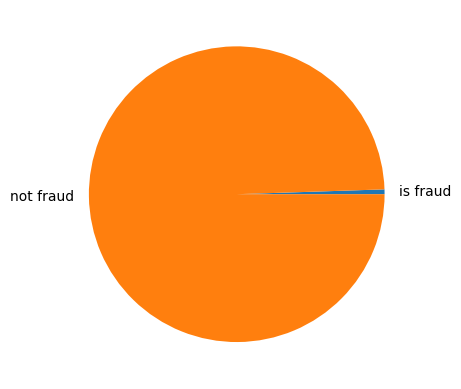

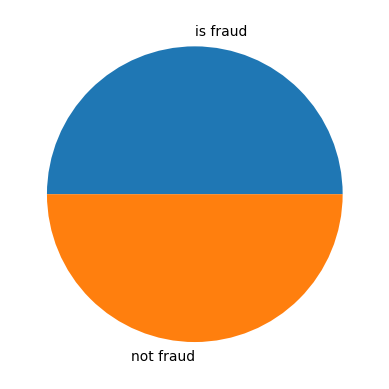

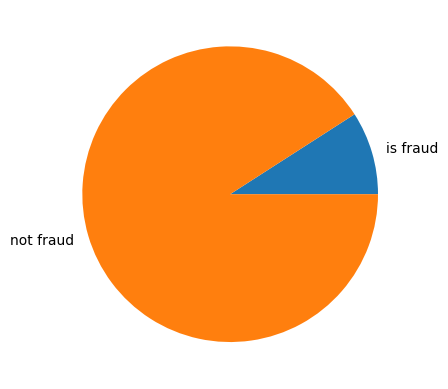

In [93]:
## visualizing original, oversampled and undersampled training data
plt.pie([len(data[data['is_fraud']==1]),len(data[data['is_fraud']==0])],labels=['is fraud', 'not fraud'])
plt.show()

plt.pie([len(oversampled_train[oversampled_train['is_fraud']==1]),len(oversampled_train[oversampled_train['is_fraud']==0])],labels=['is fraud', 'not fraud'])
plt.show()

plt.pie([len(undersampled_train[undersampled_train['is_fraud']==1]),len(undersampled_train[undersampled_train['is_fraud']==0])],labels=['is fraud', 'not fraud'])
plt.show()

<h1> Training models </h1>

<h3> Random Forest Classifier </h3>

In [16]:
#initial Random Forest Classifier

# RandomForestClassifier
#rf_acc = [[0.863736616065634, 5, 5], [0.863736616065634, 5, 5], [0.8657986663253618, 13, 5], [0.8657986663253618, 13, 5], [0.8663688005978006, 11, 5], [0.8663688005978006, 11, 5], [0.8665911658922666, 3, 5], [0.8665911658922666, 3, 5], [0.8670255539093629, 7, 5], [0.8670255539093629, 7, 5], [0.8672246484171987, 9, 5], [0.8672246484171987, 9, 5], [0.8881321573829156, 3, 10], [0.8881321573829156, 3, 10], [0.8905031919762327, 5, 10], [0.8905031919762327, 5, 10], [0.9116692652378404, 7, 10], [0.9116692652378404, 7, 10], [0.9169297558377354, 9, 10], [0.9169297558377354, 9, 10], [0.9181036377410788, 13, 10], [0.9181036377410788, 13, 10], [0.9212477795791091, 11, 10], [0.9212477795791091, 11, 10], [0.9636109538178311, 5, 15], [0.9636109538178311, 5, 15], [0.9644887796023798, 3, 15], [0.9644887796023798, 3, 15], [0.9714519160907147, 9, 15], [0.9714519160907147, 9, 15], [0.9742547530581692, 7, 15], [0.9742547530581692, 7, 15], [0.9783853176850221, 11, 15], [0.9783853176850221, 11, 15], [0.9796742607000369, 13, 15], [0.9796742607000369, 13, 15], [0.9891842555028947, 3, 20], [0.9891842555028947, 3, 20], [0.9919121088245408, 5, 20], [0.9919121088245408, 5, 20], [0.992779592037254, 7, 20], [0.992779592037254, 7, 20], [0.9937479153253643, 9, 20], [0.9937479153253643, 9, 20], [0.9941163694470085, 11, 20], [0.9941163694470085, 11, 20], [0.994947653658297, 13, 20], [0.994947653658297, 13, 20], [0.9957879876199415, 3, 25], [0.9967886314450383, 5, 25], [0.9969941900602713, 7, 25], [0.9972307763910113, 11, 25], [0.9972915390005456, 9, 25], [0.9973988431833402, 13, 25], [0.9975914735837788, 3, 30], [0.9980995524252038, 5, 30], [0.9982184920013135, 7, 30], [0.9982714976819711, 9, 30], [0.9983206248981903, 11, 30], [0.9984499070461357, 13, 30], [0.9988519745262455, 3, 35], [0.9989140299572593, 5, 35], [0.9989851351386293, 7, 35], [0.9990174556756156, 11, 35], [0.999058825962958, 9, 35], [0.9991066603576978, 13, 35], [0.9991312239658074, 3, 40], [0.999184229646465, 3, 45], [0.9992359425056432, 5, 40], [0.999255334827835, 5, 45], [0.9992876553648213, 7, 40], [0.999309633329972, 11, 40], [0.9993160974373693, 9, 40], [0.9993316112951227, 13, 40], [0.9993406610454789, 7, 45], [0.9993729815824652, 13, 45], [0.9993833241543009, 11, 45], [0.9993910810831775, 9, 45]]
# The loop takes long time to run, the results are appended into rf_acc, just trust them or wait for an hour

#for i in range(3,15,2):
#    for j in range(5,25,5):
#        rf = RandomForestClassifier(n_estimators=i, max_depth=j, random_state=0).fit(X_train, y_train)
#        acc = accuracy_score(rf.predict(X_test),y_test)
#        rf_acc.append([acc,i,j])

#rf_acc = sorted(rf_acc,key=lambda x: x[0],reverse=True)

In [145]:
#Finding the best model using grid search
param_grid = {
    'n_estimators': np.arange(10, 100, 10),
    'max_depth': np.arange(10, 100, 10)
}

rf_start = time.time()

rf = RandomForestClassifier(random_state=0)
rf_grid_search = GridSearchCV(rf, param_grid)
rf_grid_search.fit(X_train_under, y_train_under)

rf_end = time.time()
##Best Parameters: {'max_depth': 30, 'n_estimators': 35}
##Execution time: 23.09341367483139

In [146]:
rf_best_params = rf_grid_search.best_params_
print(f"Best Parameters: {rf_best_params}")
print(find_execution_time(rf_start, rf_end))

Best Parameters: {'max_depth': 40, 'n_estimators': 40}
Execution time: 28.804105055332183 mins
None


In [147]:
#get all results from grid search

rf_results = pd.DataFrame(rf_grid_search.cv_results_).sort_values(by='rank_test_score')
rf_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
30,3.305589,0.113100,0.059245,0.001647,40,40,"{'max_depth': 40, 'n_estimators': 40}",0.922974,0.973233,0.980803,0.976988,0.916793,0.954158,0.028155,1
57,3.513330,0.097122,0.063347,0.006314,70,40,"{'max_depth': 70, 'n_estimators': 40}",0.921582,0.973354,0.980803,0.976988,0.916066,0.953759,0.028674,2
48,3.466660,0.158120,0.060066,0.001733,60,40,"{'max_depth': 60, 'n_estimators': 40}",0.921582,0.973354,0.980803,0.976988,0.916066,0.953759,0.028674,2
39,3.400879,0.079293,0.061020,0.002395,50,40,"{'max_depth': 50, 'n_estimators': 40}",0.921582,0.973354,0.980803,0.976988,0.916066,0.953759,0.028674,2
66,3.888736,0.131955,0.069575,0.006703,80,40,"{'max_depth': 80, 'n_estimators': 40}",0.921582,0.973354,0.980803,0.976988,0.916066,0.953759,0.028674,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,0.847929,0.048351,0.017571,0.000915,70,10,"{'max_depth': 70, 'n_estimators': 10}",0.922066,0.963241,0.974020,0.971477,0.907467,0.947654,0.027479,76
63,0.850483,0.055949,0.016803,0.001216,80,10,"{'max_depth': 80, 'n_estimators': 10}",0.922066,0.963241,0.974020,0.971477,0.907467,0.947654,0.027479,76
45,0.885228,0.031527,0.017858,0.001162,60,10,"{'max_depth': 60, 'n_estimators': 10}",0.922066,0.963241,0.974020,0.971477,0.907467,0.947654,0.027479,76
36,0.873960,0.034475,0.018788,0.002327,50,10,"{'max_depth': 50, 'n_estimators': 10}",0.922066,0.963241,0.974020,0.971477,0.907467,0.947654,0.027479,76


In [148]:
rf_1_acc = get_params_as_list(rf_results, 0)
rf_2_acc = get_params_as_list(rf_results, rf_results.index[int(rf_results['rank_test_score'].quantile(0.25))])
rf_3_acc = get_params_as_list(rf_results, rf_results.index[int(rf_results['rank_test_score'].quantile(0.5))])
rf_4_acc = get_params_as_list(rf_results, rf_results.index[int(rf_results['rank_test_score'].quantile(0.75))])
rf_5_acc = get_params_as_list(rf_results, rf_results.index[-1])

In [149]:
print(rf_1_acc)
print(rf_2_acc)
print(rf_3_acc)
print(rf_4_acc)
print(rf_5_acc)

[0.9541582634960827, 40, 40]
[0.9521356227415438, 20, 50]
[0.9476543079255653, 10, 80]
[0.9489140792482369, 40, 20]
[0.9524019738603708, 20, 10]


In [150]:
rf_1 = RandomForestClassifier(n_estimators=rf_1_acc[1], max_depth=rf_1_acc[2], random_state=0).fit(X_train, y_train)
rf_2 = RandomForestClassifier(n_estimators=rf_2_acc[1], max_depth=rf_2_acc[2], random_state=0).fit(X_train, y_train)
rf_3 = RandomForestClassifier(n_estimators=rf_3_acc[1], max_depth=rf_3_acc[2], random_state=0).fit(X_train, y_train)
rf_4 = RandomForestClassifier(n_estimators=rf_4_acc[1], max_depth=rf_4_acc[2], random_state=0).fit(X_train, y_train)
rf_5 = RandomForestClassifier(n_estimators=rf_5_acc[1], max_depth=rf_5_acc[2], random_state=0).fit(X_train, y_train)

Accuracy of rf_1 model on validation data from test_train_split:  0.9972935913538882
Accuracy of rf_1 model on test data from the separate file:  0.9974663499604117


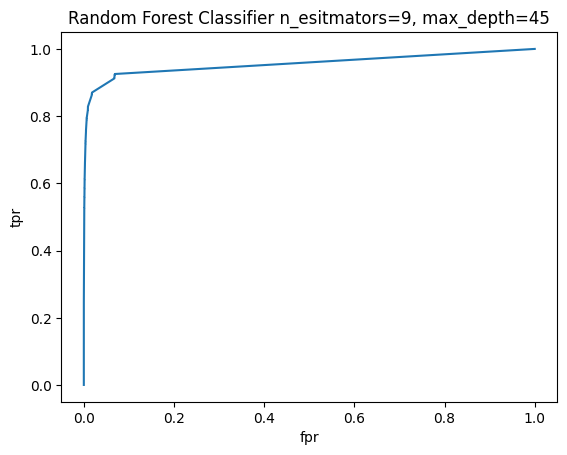

Confusion matrix for the test data from train test split


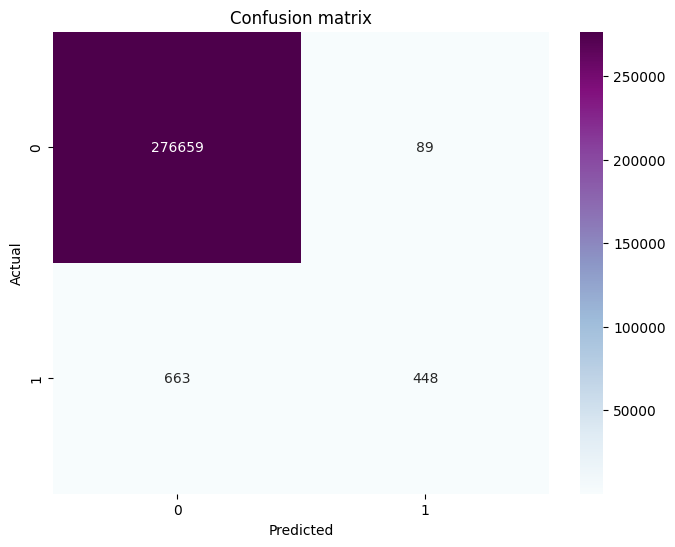

Confusion matrix for the separate test file


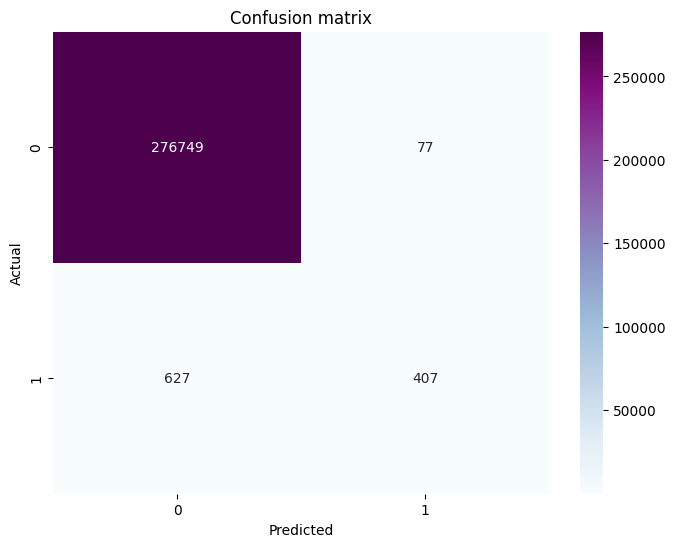

Accuracy of rf_2 model on validation data from test_train_split:  0.9971532323948478
Accuracy of rf_2 model on test data from the separate file:  0.9973331893759447


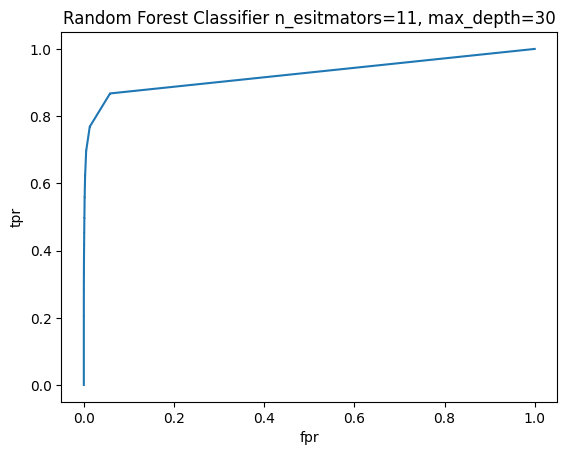

Confusion matrix for the test data from train test split


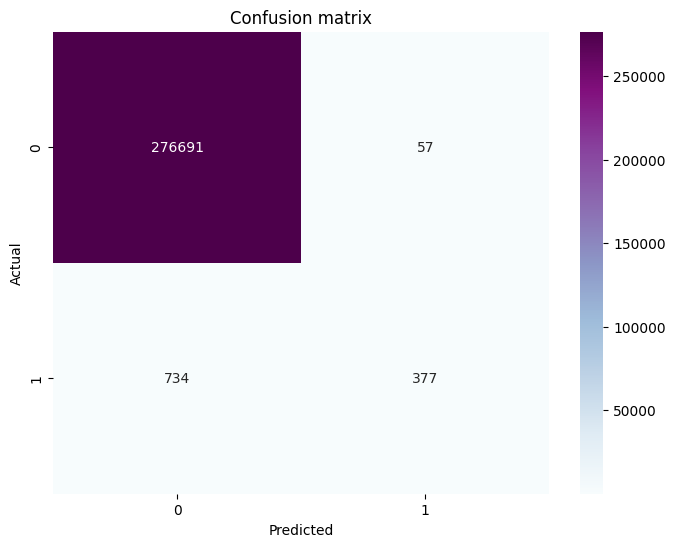

Confusion matrix for the separate test file


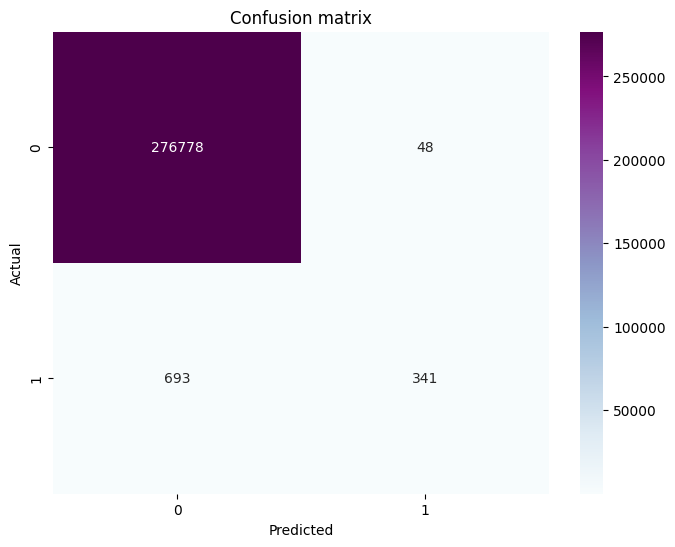

Accuracy of rf_3 model on validation data from test_train_split:  0.9971280397611738
Accuracy of rf_3 model on test data from the separate file:  0.9972396170733463


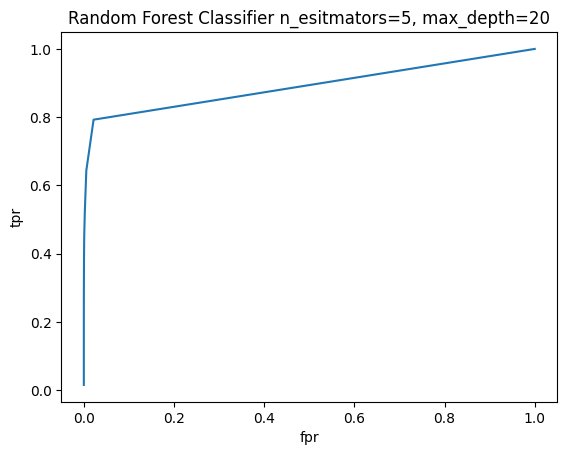

Confusion matrix for the test data from train test split


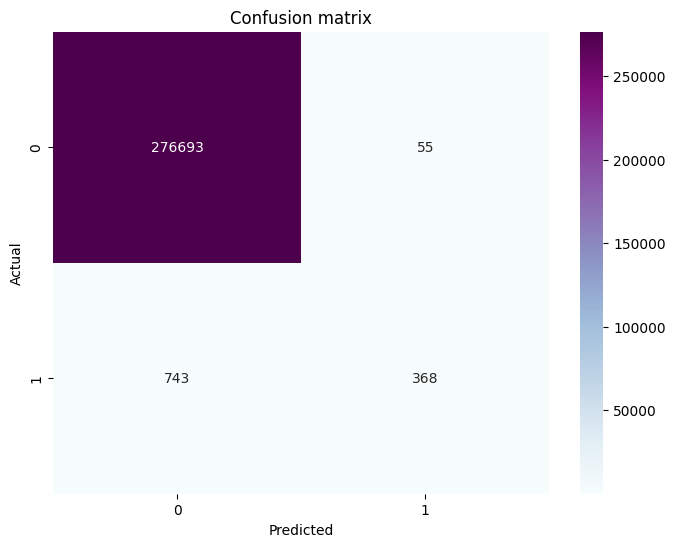

Confusion matrix for the separate test file


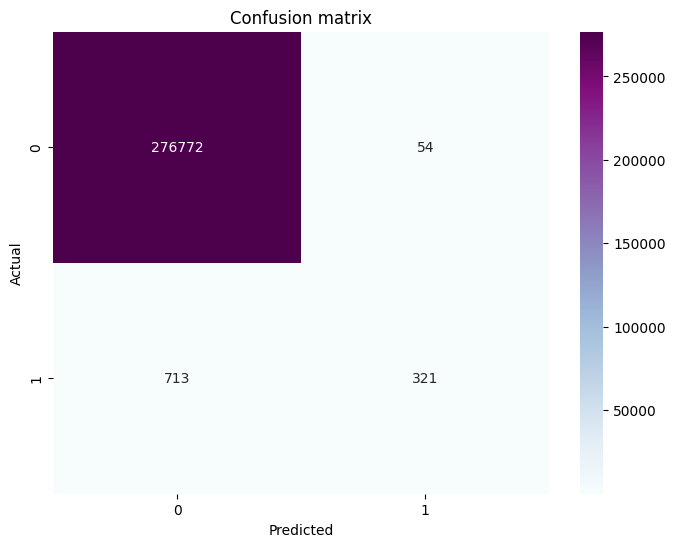

Accuracy of rf_4 model on validation data from test_train_split:  0.9932879625997358
Accuracy of rf_4 model on test data from the separate file:  0.9932987835600662


KeyboardInterrupt: 

In [152]:
### ROC curve of rf_1
print("Accuracy of rf_1 model on validation data from test_train_split: ",accuracy_score(rf_1.predict(X_test),y_test))
print("Accuracy of rf_1 model on test data from the separate file: ",accuracy_score(rf_1.predict(X_val),y_val))
plot_ROC(test_cleaned,rf_1,'is_fraud','Random Forest Classifier n_esitmators=9, max_depth=45')


y_true = y_val
y_pred = rf_1.predict(X_test)
y_pred_testfile = rf_1.predict(X_val)
print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

print("Accuracy of rf_2 model on validation data from test_train_split: ",accuracy_score(rf_2.predict(X_test),y_test))
print("Accuracy of rf_2 model on test data from the separate file: ",accuracy_score(rf_2.predict(X_val),y_val))
plot_ROC(test_cleaned,rf_2,'is_fraud','Random Forest Classifier n_esitmators=11, max_depth=30')
y_true = y_val
y_pred = rf_2.predict(X_test)
y_pred_testfile = rf_2.predict(X_val)
print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

print("Accuracy of rf_3 model on validation data from test_train_split: ",accuracy_score(rf_3.predict(X_test),y_test))
print("Accuracy of rf_3 model on test data from the separate file: ",accuracy_score(rf_3.predict(X_val),y_val))
plot_ROC(test_cleaned,rf_3,'is_fraud','Random Forest Classifier n_esitmators=5, max_depth=20')
y_true = y_val
y_pred = rf_3.predict(X_test)
y_pred_testfile = rf_3.predict(X_val)

print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

print("Accuracy of rf_4 model on validation data from test_train_split: ",accuracy_score(rf_4.predict(X_test),y_test))
print("Accuracy of rf_4 model on test data from the separate file: ",accuracy_score(rf_4.predict(X_val),y_val))
plot_ROC(test_cleaned,rf_4,'is_fraud','Random Forest Classifier n_esitmators=9, max_depth=10')
y_true = y_val
y_pred = rf_4.predict(X_test)
y_pred_testfile = rf_4.predict(X_val)

print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

print("Accuracy of rf_5 model on validation data from test_train_split: ",accuracy_score(rf_5.predict(X_test),y_test))
print("Accuracy of rf_5 model on test data from the separate file: ",accuracy_score(rf_5.predict(X_val),y_val))
plot_ROC(test_cleaned,rf_5,'is_fraud','Random Forest Classifier n_esitmators=5, max_depth=5')
y_true = y_val
y_pred = rf_5.predict(X_test)
y_pred_testfile = rf_5.predict(X_val)

print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)



Confusion matrix for the test data from train test split


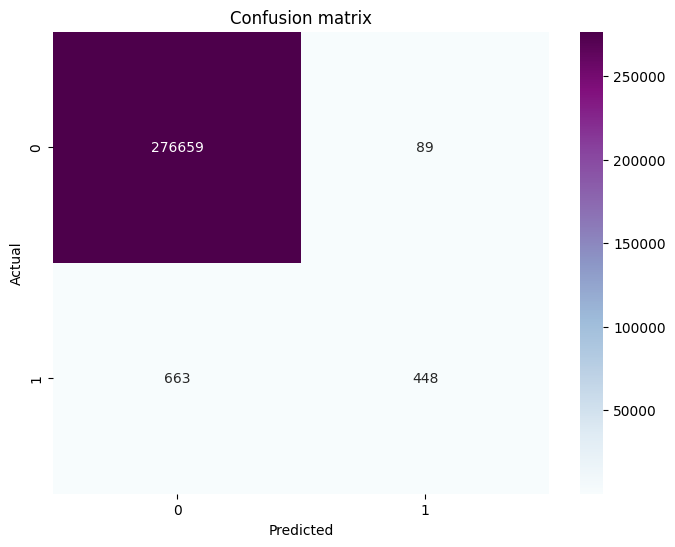

In [156]:
y_true = y_val
y_pred = rf_1.predict(X_test)
y_pred_testfile = rf_1.predict(X_val)
print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)

<p> By using a Random Forest Classifier it seems that the modes with better accuracy tend to have a greater type 2 error rate than models with lesser accuracy on the validation data. It also occurs that models with a smaller depth and a smaller n_estimators tend to classify fraudulet transactions better. At first we trained a model where we dropped the job category but after feature engineering all the jobs and separating them into 10 categories the model improved significantly. This was achieved with a training dataset that was oversampled. Now it's worth investigating if an undersampled dataset would work aswell, as it would reduce the training time for each model</p>

In [ ]:
rf_1 = RandomForestClassifier(n_estimators=rf_1_acc[1], max_depth=rf_1_acc[2], random_state=0).fit(X_train_under, y_train_under)
rf_2 = RandomForestClassifier(n_estimators=rf_2_acc[1], max_depth=rf_2_acc[2], random_state=0).fit(X_train_under, y_train_under)
rf_3 = RandomForestClassifier(n_estimators=rf_3_acc[1], max_depth=rf_3_acc[2], random_state=0).fit(X_train_under, y_train_under)
rf_4 = RandomForestClassifier(n_estimators=rf_4_acc[1], max_depth=rf_4_acc[2], random_state=0).fit(X_train_under, y_train_under)
rf_5 = RandomForestClassifier(n_estimators=rf_5_acc[1], max_depth=rf_5_acc[2], random_state=0).fit(X_train_under, y_train_under)

In [158]:
print("Accuracy of rf_1 model on validation data from test_train_split: ",accuracy_score(rf_1.predict(X_test_under),y_test_under))
print("Accuracy of rf_1 model on test data from the separate file: ",accuracy_score(rf_1.predict(X_val),y_val))
plot_ROC(test_cleaned_onehot,rf_1,'is_fraud','Random Forest Classifier n_esitmators=9, max_depth=45')

y_true = y_val
y_pred = rf_1.predict(X_test_under)
y_pred_testfile = rf_1.predict(X_val)
print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test_under,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

print("Accuracy of rf_2 model on validation data from test_train_split: ",accuracy_score(rf_2.predict(X_test_under),y_test_under))
print("Accuracy of rf_2 model on test data from the separate file: ",accuracy_score(rf_2.predict(X_val),y_val))
plot_ROC(test_cleaned_onehot,rf_1,'is_fraud','Random Forest Classifier n_esitmators=11, max_depth=30')
y_true = y_val
y_pred = rf_2.predict(X_test_under)
y_pred_testfile = rf_2.predict(X_val)
print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test_under,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

print("Accuracy of rf_3 model on validation data from test_train_split: ",accuracy_score(rf_3.predict(X_test_under),y_test_under))
print("Accuracy of rf_3 model on test data from the separate file: ",accuracy_score(rf_3.predict(X_val),y_val))
plot_ROC(test_cleaned_onehot,rf_1,'is_fraud','Random Forest Classifier n_esitmators=5, max_depth=20')
y_true = y_val
y_pred = rf_3.predict(X_test_under)
y_pred_testfile = rf_3.predict(X_val)

print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test_under,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

print("Accuracy of rf_4 model on validation data from test_train_split: ",accuracy_score(rf_4.predict(X_test_under),y_test_under))
print("Accuracy of rf_4 model on test data from the separate file: ",accuracy_score(rf_4.predict(X_val),y_val))
plot_ROC(test_cleaned_onehot,rf_1,'is_fraud','Random Forest Classifier n_esitmators=9, max_depth=10')
y_true = y_val
y_pred = rf_4.predict(X_test_under)
y_pred_testfile = rf_4.predict(X_val)

print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test_under,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

print("Accuracy of rf_5 model on validation data from test_train_split: ",accuracy_score(rf_5.predict(X_test_under),y_test_under))
print("Accuracy of rf_5 model on test data from the separate file: ",accuracy_score(rf_5.predict(X_val),y_val))
plot_ROC(test_cleaned_onehot,rf_1,'is_fraud','Random Forest Classifier n_esitmators=5, max_depth=5')
y_true = y_val
y_pred = rf_5.predict(X_test_under)
y_pred_testfile = rf_5.predict(X_val)

print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test_under,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

NameError: name 'X_test_under' is not defined

In [ ]:
rf_undersampled_bestgrid = RandomForestClassifier(n_estimators=35,max_depth=30).fit(X_train_under,y_train_under)

print("Accuracy of model on validation data from test_train_split: ",accuracy_score(rf_undersampled_bestgrid.predict(X_test_under),y_test_under))
print("Accuracy of model on test data from the separate file: ",accuracy_score(rf_undersampled_bestgrid.predict(X_val),y_val))
plot_ROC(test_cleaned_onehot,rf_undersampled_bestgrid,'is_fraud','Random Forest Classifier n_esitmators=35, max_depth=30')
y_true = y_val
y_pred = rf_undersampled_bestgrid.predict(X_test_under)
y_pred_testfile = rf_undersampled_bestgrid.predict(X_val)

print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test_under,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

<h3> Decision Tree Classifier</h3>

In [ ]:
#first test with decision trees

#dt1_start = time.time()
#decision_tree = tree.DecisionTreeClassifier()
#decision_tree.fit(X_train, y_train)
#dt2_end = time.time()

#print(find_execution_time(dt1_start, dt1_end))
#tree.plot_tree(decision_tree)

In [22]:
#grid search, some results may vary if run again as minmaxscaling has been slighltly adjusted
#not to work on onehotted columns in the meantime
#changes like this have not previously had significant impact on the results
param_grid = {
    'max_depth': np.arange(3, 15, 2),
    'min_samples_split': np.arange(10, 500, 20) 
}

dt2_start = time.time()

tree_clf = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(tree_clf, param_grid)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

dt2_end = time.time()

print(f"Best Parameters: {best_params}")

Best Parameters: {'max_depth': 13, 'min_samples_split': 70}
('Execution time:', 120.0564967195193, 'mins')


In [28]:
find_execution_time(dt2_start, dt2_end)

Execution time: 120.0564967195193 mins


[Text(0.7963270707563921, 0.9642857142857143, 'x[0] <= 0.008\ngini = 0.5\nsamples = 2578338\nvalue = [1289169, 1289169]'),
 Text(0.6203530051491477, 0.8928571428571429, 'x[0] <= 0.001\ngini = 0.322\nsamples = 1569033\nvalue = [1252616, 316417]'),
 Text(0.45807994495738635, 0.8214285714285714, 'x[12] <= 0.5\ngini = 0.465\nsamples = 721739\nvalue = [456299, 265440]'),
 Text(0.3736794211647727, 0.75, 'x[0] <= 0.001\ngini = 0.384\nsamples = 615462\nvalue = [456212, 159250]'),
 Text(0.2935236150568182, 0.6785714285714286, 'x[13] <= 0.5\ngini = 0.269\nsamples = 477808\nvalue = [401115, 76693]'),
 Text(0.20210404829545456, 0.6071428571428571, 'x[19] <= 0.5\ngini = 0.212\nsamples = 454691\nvalue = [399785, 54906]'),
 Text(0.12633167613636365, 0.5357142857142857, 'x[23] <= 0.5\ngini = 0.144\nsamples = 388930\nvalue = [358621, 30309]'),
 Text(0.06498579545454546, 0.4642857142857143, 'x[17] <= 0.5\ngini = 0.061\nsamples = 334796\nvalue = [324269, 10527]'),
 Text(0.024147727272727272, 0.3928571428

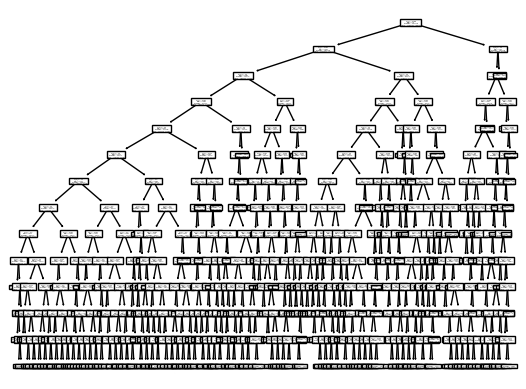

In [29]:
tree2 = tree.DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'])
tree2.fit(X_train, y_train)
tree.plot_tree(tree2)

In [75]:
dt_results = pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')
dt_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
128,13.104139,0.579674,0.068296,0.003019,13,70,"{'max_depth': 13, 'min_samples_split': 70}",0.511327,0.979070,0.979322,0.981023,0.509329,0.792014,0.229998,1
125,13.123699,0.366005,0.068866,0.002575,13,10,"{'max_depth': 13, 'min_samples_split': 10}",0.511327,0.979066,0.979324,0.981023,0.509329,0.792014,0.229997,2
129,12.971567,0.424337,0.068516,0.002120,13,90,"{'max_depth': 13, 'min_samples_split': 90}",0.511327,0.979064,0.979322,0.981023,0.509331,0.792013,0.229996,3
130,12.980978,0.373817,0.067759,0.002657,13,110,"{'max_depth': 13, 'min_samples_split': 110}",0.511327,0.979068,0.979320,0.981023,0.509329,0.792013,0.229997,4
126,13.120645,0.389879,0.068625,0.001889,13,30,"{'max_depth': 13, 'min_samples_split': 30}",0.511327,0.979070,0.979320,0.981021,0.509329,0.792013,0.229997,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,4.366463,0.084886,0.061709,0.000460,3,450,"{'max_depth': 3, 'min_samples_split': 450}",0.416433,0.905810,0.906740,0.906979,0.405651,0.708323,0.242753,126
23,4.324406,0.090653,0.062444,0.000196,3,470,"{'max_depth': 3, 'min_samples_split': 470}",0.416433,0.905810,0.906740,0.906979,0.405651,0.708323,0.242753,126
24,4.384942,0.053700,0.061780,0.000612,3,490,"{'max_depth': 3, 'min_samples_split': 490}",0.416433,0.905810,0.906740,0.906979,0.405651,0.708323,0.242753,126
12,4.317284,0.044613,0.062537,0.001082,3,250,"{'max_depth': 3, 'min_samples_split': 250}",0.416433,0.905810,0.906740,0.906979,0.405651,0.708323,0.242753,126


<p> Let's look at the models that are the best, worst, and one from each quartile once again.

In [76]:
dt_1_acc = get_params_as_list2(dt_results, 0)
dt_2_acc = get_params_as_list2(dt_results, dt_results.index[int(rf_results['rank_test_score'].quantile(0.25))])
dt_3_acc = get_params_as_list2(dt_results, dt_results.index[int(rf_results['rank_test_score'].quantile(0.5))])
dt_4_acc = get_params_as_list2(dt_results, dt_results.index[int(rf_results['rank_test_score'].quantile(0.75))])
dt_5_acc = get_params_as_list2(dt_results, dt_results.index[-1])

In [77]:
dt_1 = tree.DecisionTreeClassifier(max_depth=dt_1_acc[1], min_samples_split=dt_1_acc[2], random_state=0).fit(X_train, y_train)
dt_2 = tree.DecisionTreeClassifier(max_depth=dt_2_acc[1], min_samples_split=dt_2_acc[2], random_state=0).fit(X_train, y_train)
dt_3 = tree.DecisionTreeClassifier(max_depth=dt_3_acc[1], min_samples_split=dt_3_acc[2], random_state=0).fit(X_train, y_train)
dt_4 = tree.DecisionTreeClassifier(max_depth=dt_4_acc[1], min_samples_split=dt_4_acc[2], random_state=0).fit(X_train, y_train)
dt_5 = tree.DecisionTreeClassifier(max_depth=dt_5_acc[1], min_samples_split=dt_5_acc[2], random_state=0).fit(X_train, y_train)

Accuracy of dt_1 model on validation data from test_train_split:  0.9701935154160923
Accuracy of dt_1 model on test data from the separate file:  0.9696069963290866


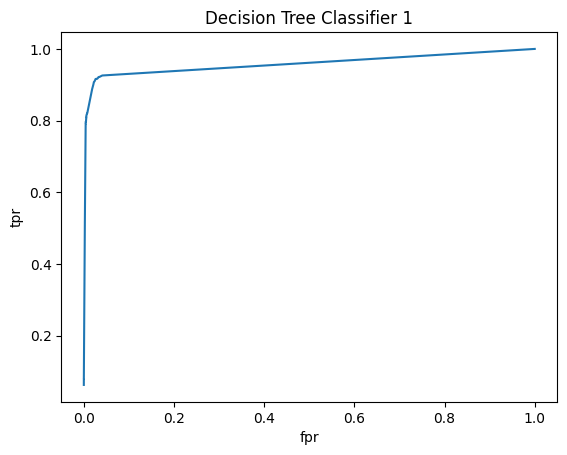

Confusion matrix for the test data from train test split


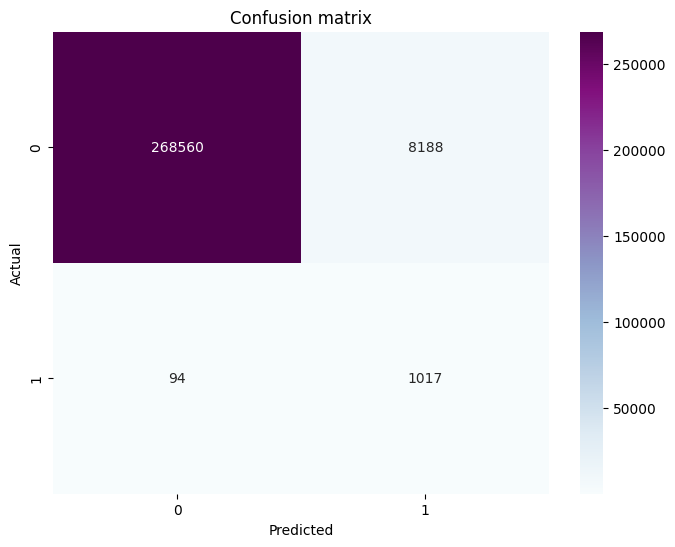

Confusion matrix for the separate test file


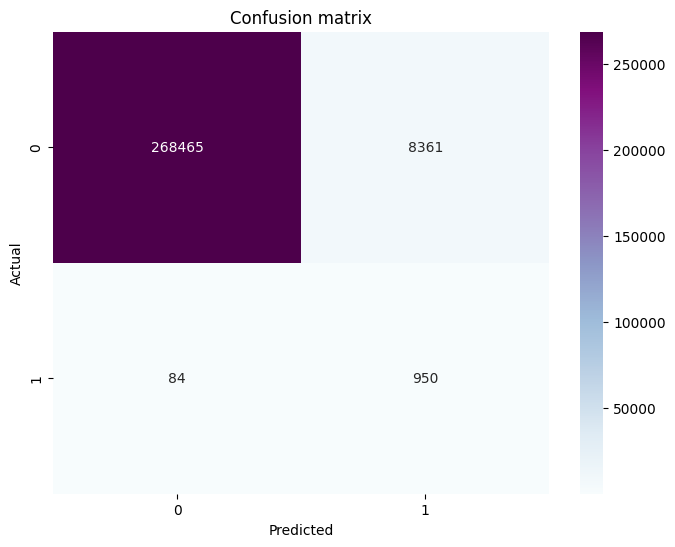

Accuracy of dt_2 model on validation data from test_train_split:  0.9751168758255087
Accuracy of dt_2 model on test data from the separate file:  0.9757971640394443


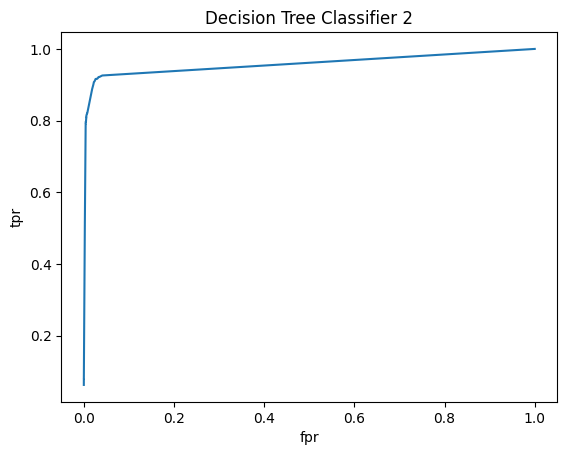

Confusion matrix for the test data from train test split


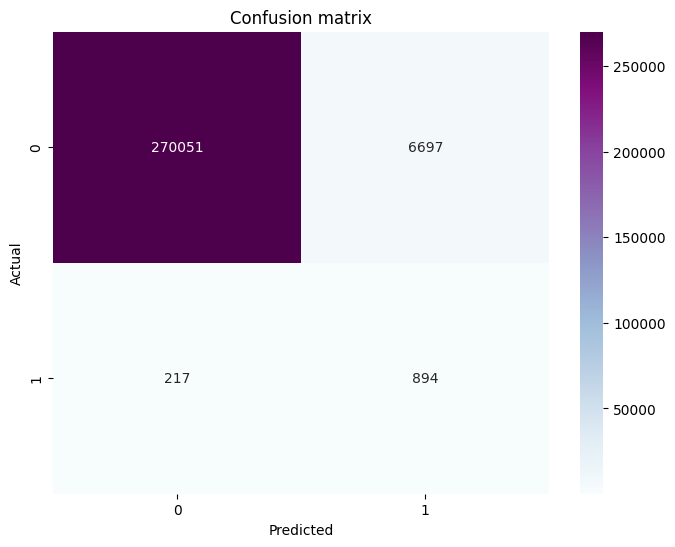

Confusion matrix for the separate test file


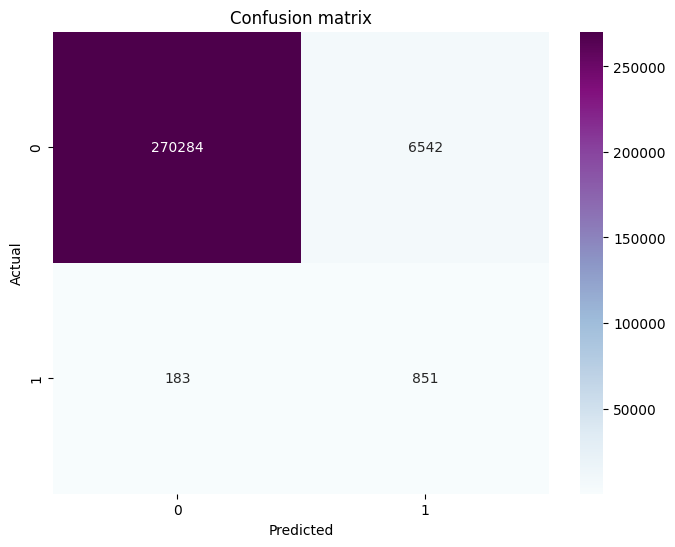

Accuracy of dt_3 model on validation data from test_train_split:  0.9370292126582187
Accuracy of dt_3 model on test data from the separate file:  0.9366659468797236


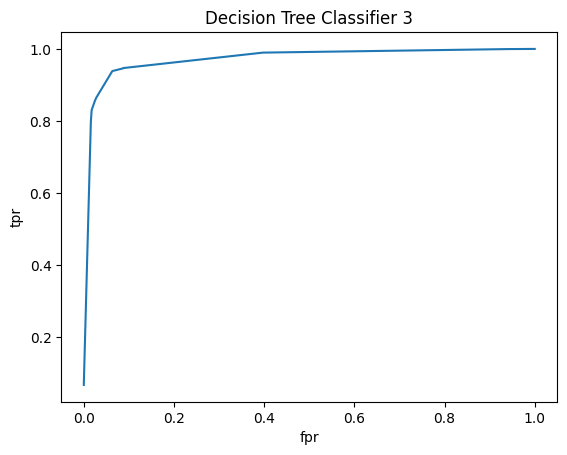

Confusion matrix for the test data from train test split


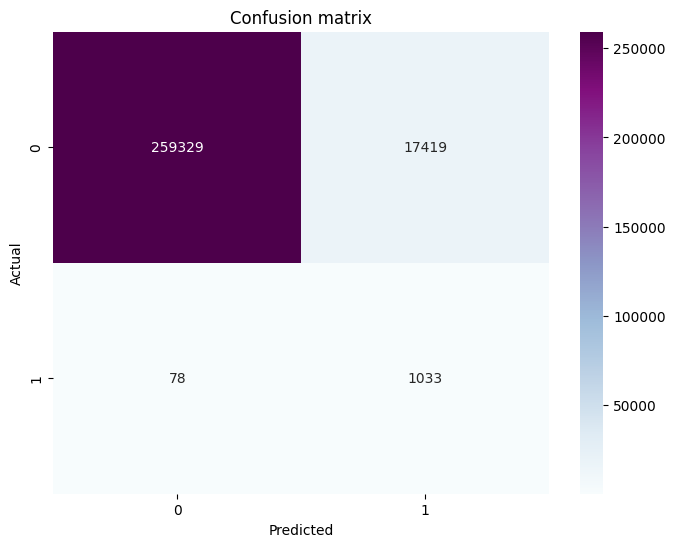

Confusion matrix for the separate test file


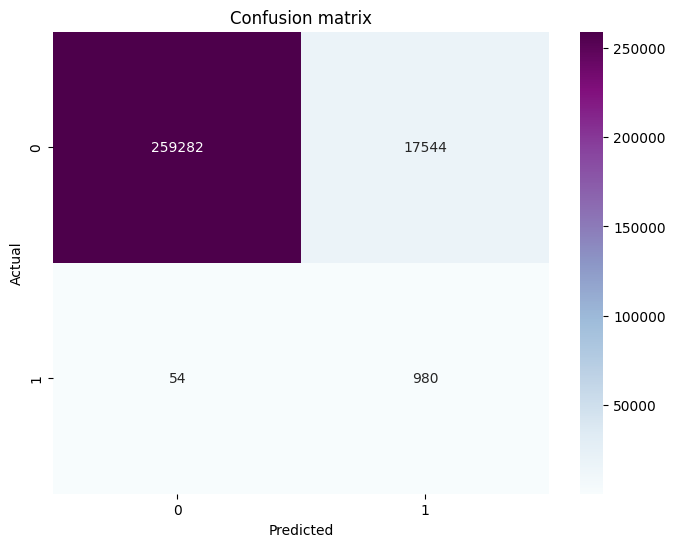

Accuracy of dt_4 model on validation data from test_train_split:  0.9361978557469796
Accuracy of dt_4 model on test data from the separate file:  0.9359389620672282


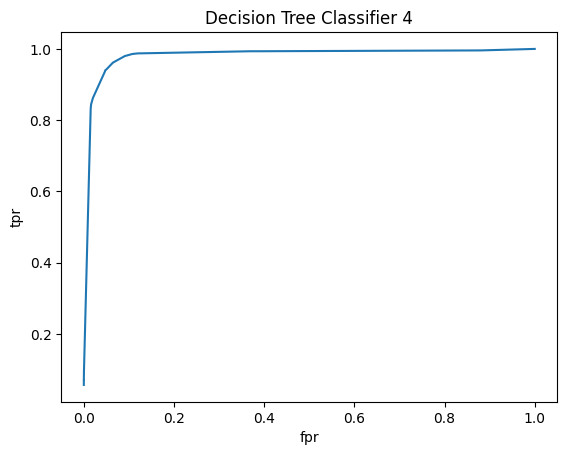

Confusion matrix for the test data from train test split


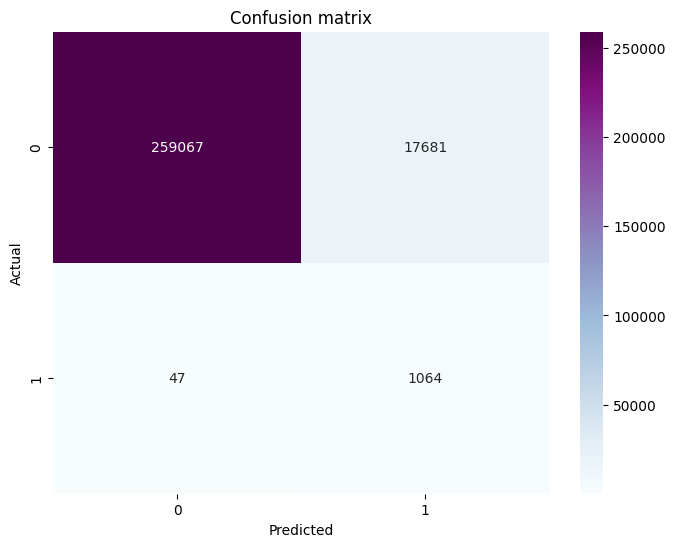

Confusion matrix for the separate test file


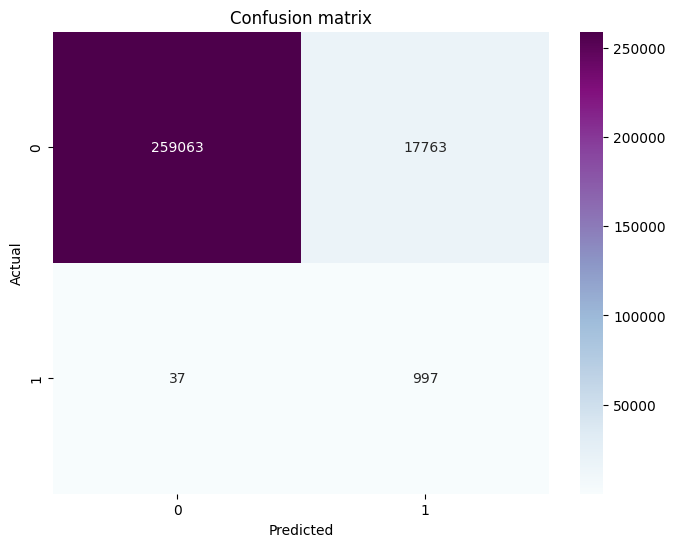

Accuracy of dt_5 model on validation data from test_train_split:  0.9701935154160923
Accuracy of dt_5 model on test data from the separate file:  0.9696069963290866


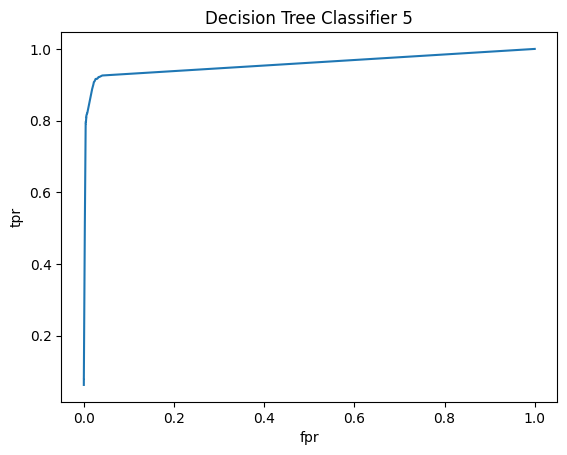

Confusion matrix for the test data from train test split


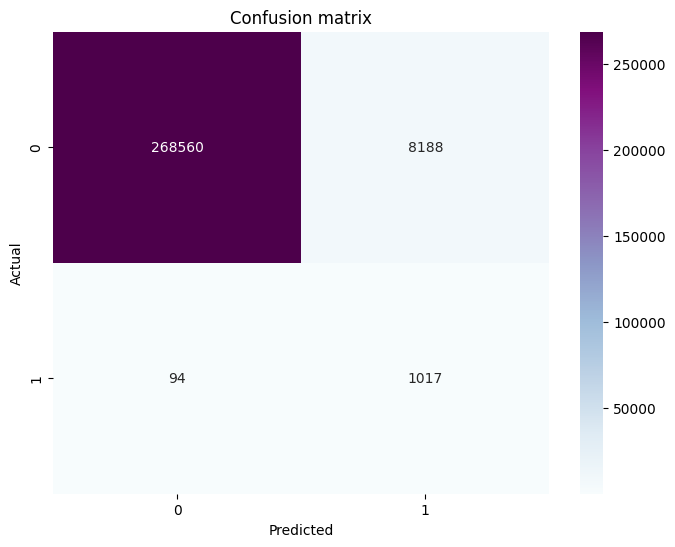

Confusion matrix for the separate test file


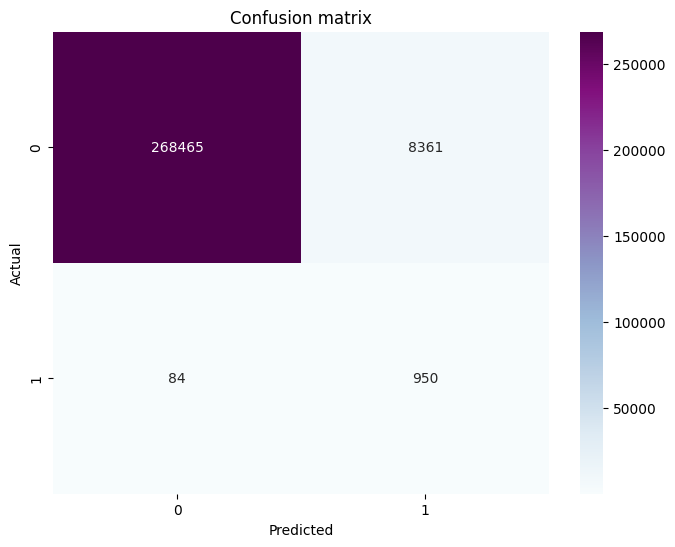

In [159]:
print("Accuracy of dt_1 model on validation data from test_train_split: ",accuracy_score(dt_1.predict(X_test),y_test))
print("Accuracy of dt_1 model on test data from the separate file: ",accuracy_score(dt_1.predict(X_val),y_val))
plot_ROC(test_cleaned,dt_1,'is_fraud','Decision Tree Classifier 1')


y_true = y_val
y_pred = dt_1.predict(X_test)
y_pred_testfile = dt_1.predict(X_val)
print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

print("Accuracy of dt_2 model on validation data from test_train_split: ",accuracy_score(dt_2.predict(X_test),y_test))
print("Accuracy of dt_2 model on test data from the separate file: ",accuracy_score(dt_2.predict(X_val),y_val))
plot_ROC(test_cleaned,dt_1,'is_fraud','Decision Tree Classifier 2')
y_true = y_val
y_pred = dt_2.predict(X_test)
y_pred_testfile = dt_2.predict(X_val)
print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

print("Accuracy of dt_3 model on validation data from test_train_split: ",accuracy_score(dt_3.predict(X_test),y_test))
print("Accuracy of dt_3 model on test data from the separate file: ",accuracy_score(dt_3.predict(X_val),y_val))
plot_ROC(test_cleaned,dt_3,'is_fraud','Decision Tree Classifier 3')
y_true = y_val
y_pred = dt_3.predict(X_test)
y_pred_testfile = dt_3.predict(X_val)

print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

print("Accuracy of dt_4 model on validation data from test_train_split: ",accuracy_score(dt_4.predict(X_test),y_test))
print("Accuracy of dt_4 model on test data from the separate file: ",accuracy_score(dt_4.predict(X_val),y_val))
plot_ROC(test_cleaned,dt_4,'is_fraud','Decision Tree Classifier 4')
y_true = y_val
y_pred = dt_4.predict(X_test)
y_pred_testfile = dt_4.predict(X_val)

print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

print("Accuracy of dt_5 model on validation data from test_train_split: ",accuracy_score(dt_5.predict(X_test),y_test))
print("Accuracy of dt_5 model on test data from the separate file: ",accuracy_score(dt_5.predict(X_val),y_val))
plot_ROC(test_cleaned,dt_1,'is_fraud','Decision Tree Classifier 5')
y_true = y_val
y_pred = dt_5.predict(X_test)
y_pred_testfile = dt_5.predict(X_val)

print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

<p> The best model seems to be the one we looked at first.

Confusion matrix for the test data from train test split


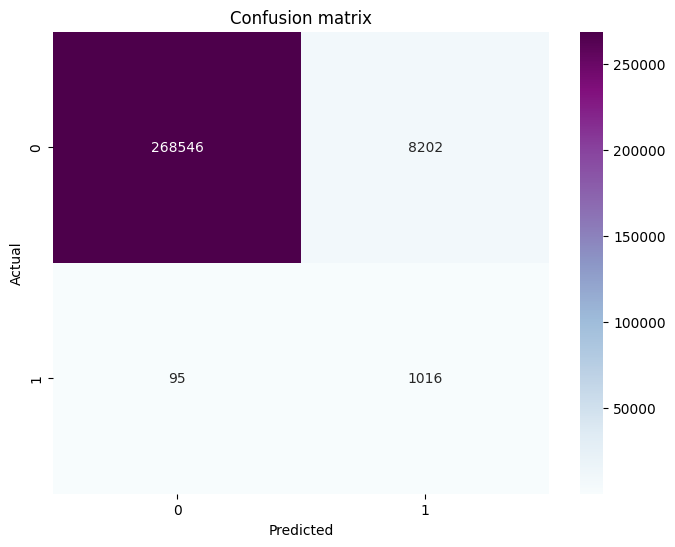

Confusion matrix for the separate test file


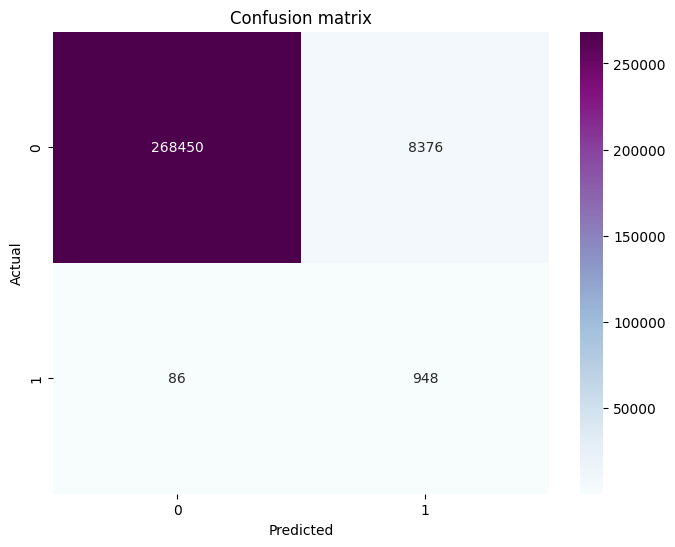

In [30]:
#validation and visualisation
y_true = y_val
y_pred = tree2.predict(X_test)
y_pred_testfile = tree2.predict(X_val)
print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)